Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [13]:
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode

import scipy.stats as stats
from scipy.stats import bootstrap

from IPython.display import display

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [15]:
def get_data(public_key: str, sep: str) -> pd.DataFrame:
    '''
    Загружает csv-файл с яндекс диска и возвращает его в виде pandas DataFrame.

    Параметры:
    - public_key: Публичная ссылка на файл на яндекс диске.
    - sep: Разделитель в csv-файле. По умолчанию ','.

    Возвращает:
    - pd.DataFrame: Датафрейм с данными из csv-файла.
    '''
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    return pd.read_csv(download_url, sep=sep)

In [16]:
active_studs = get_data('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', sep=',')
checks = get_data('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep=';')
group_add = get_data('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', sep=',')

In [17]:
download_link = 'https://s89vlx.storage.yandex.net/rdisk/da8c9bfc9ddef881d71064e03e152e0e863166bf2d9bc9cd55ba81b95cb08bc3/64e7db7d/fKqInKw3d7bLFOeFnMGnhLWIS9AmXMMXWGR17A-BkO3-qg5Wp8tUAp7lxoJJvJyG8pjltSuuxShICmGl2FDiJhbsM4PC04KdB-NoZUjfeOOr8npumZHI4midPdWhecNq?uid=992018421&filename=%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_groups.csv&disposition=attachment&hash=&limit=0&content_type=text%2Fplain&owner_uid=992018421&fsize=724984&hid=4b9098e1d545e562c779de19f9f64e2f&media_type=spreadsheet&tknv=v2&etag=6517d04ad247593dab021669e7065354&rtoken=SudwIokDkN1x&force_default=yes&ycrid=na-31a015b7e140e202ed35bdcec299f6d7-downloader4h&ts=603b2dce01940&s=943609a9bd6d3e3a15a4d834f2016177411f1cf91a67f9bdeb6e29f504b070cf&pb=U2FsdGVkX1_swfdPh-FrRXFaOFayOBGLD1Wz1Q8RNN2LiMjR4dRYf9snRG0saQ4ebmovkIjzZLppYzcG5Nuejops5LEXg_CayV-AYRvCjC82h3fl_MqAKM4HzjfEmij7'
groups = pd.read_csv(download_link, sep=';')

In [18]:
def conf_inter_plot(ax, means: list, conf_intervals: list, metric_name: str):
        '''
        Функция принимает списки средних значений для двух групп и соответствующих 
        им доверительных интервалов, возвращая график, на котором наглядно 
        демонстрируется пересечение этих доверительных интервалов.

        means - [mean(Group A), mean(Group B)],
        conf_intervals - [confidence_interval(Group A), confidence_interval(Group B)]
        '''

        groups = ['Group A', 'Group B']
        positions = [0, 1]

        for i, (group, pos) in enumerate(zip(groups, positions)):
            ax.plot(conf_intervals[i], [pos, pos], color='blue')  # Доверительный интервал
            ax.plot(means[i], pos, 'o', color='red')  # Среднее значение

            if group == 'Group A':
                ax.axvline(x=conf_intervals[i][0], linestyle='--', color='black')
                ax.axvline(x=conf_intervals[i][1], linestyle='--', color='black')

        ax.set_yticks(positions)
        ax.set_yticklabels(groups)
        ax.set_xlabel(metric_name, fontsize=14, fontweight='bold')
        ax.set_title(f'Confidence Intervals of {metric_name}')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

In [19]:
def compare_metrics(ax, valueA: float, valueB: float, metric_name: str):
    """
    Сравнивает метрику двух групп, рисуя график.

    :param valueA: Значение метрики для группы A.
    :param valueB: Значение метрики для группы B.
    """
    
    groups = ['Group A', 'Group B']
    values = [valueA, valueB]
    colors = ['blue', 'red']
    
    bars = ax.bar(groups, values, color=colors, width=0.5)
    
    # Отображение значений на графике
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, str(round(height, 3)),
                ha='center', va='bottom')
    
    ax.set_title("Comparison of metrics between groups")
    ax.set_xlabel(metric_name, fontsize=14, fontweight='bold')
    ax.set_ylabel("Metric values")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

In [20]:
class MetricsCalculator:
    def __init__(self, 
                 active_studs: pd.DataFrame, 
                 checks: pd.DataFrame, 
                 groups: pd.DataFrame, 
                 group_add: pd.DataFrame,
                 conf_int_plot,
                 compare_metrics) -> pd.DataFrame:
        
        self.active_studs = active_studs
        self.checks = checks
        self.groups = groups
        self.group_add = group_add
        self.conf_inter_plot = conf_inter_plot
        self.compare_metrics = compare_metrics
        
        self.df = None
        self.grp_a = None
        self.grp_b = None
        
        self.data_processing()
    
    def data_processing(self):
        # меняем названия колонок на названия из group
        col_names = self.group_add.columns.tolist()
        group_add = self.group_add.rename(columns={col_names[0]: 'id', col_names[1]: 'grp'})
        
        # присоелиняем дополнителные данные
        groups = pd.concat([self.groups, group_add], ignore_index=True)

        df = groups.merge(self.active_studs, left_on='id', right_on='student_id') \
                    .merge(self.checks, on='student_id', how='left') \
                    .drop('student_id', axis=1)
        df['payment'] = (~df['rev'].isna()).astype(int)
        
        self.df = df
        self.grp_a = df.query("grp == 'A'")
        self.grp_b = df.query("grp == 'B'")
    
    def intervals_intersect(self, a, b, c, d):
        '''
        Возвращаем True, если доверительные интервалы пересекаются
        '''
        return a <= d and b >= c
    
    def cr(self):
        '''
        Вычисляет все нужные значения для метрики CR
        '''
        # значения метрики для обоих групп
        self.value_cr_a = np.mean(self.grp_a.payment)
        self.value_cr_b = np.mean(self.grp_b.payment)
        
        # bootstrap
        self.cr_int_1 = bootstrap((self.grp_a.payment, ), np.mean).confidence_interval
        self.cr_int_2 = bootstrap((self.grp_b.payment, ), np.mean).confidence_interval
        cr_df = pd.DataFrame({'Intersect confidence intervals': [self.intervals_intersect(*self.cr_int_1, *self.cr_int_2)]})
        cr_df.index = ['CR']
        return cr_df

    def arpu(self):
        '''
        Вычисляет все нужные значения для метрики ARPU
        '''
        # значения метрики для обоих групп
        self.value_arpu_a = np.mean(self.grp_a.rev.fillna(0))
        self.value_arpu_b = np.mean(self.grp_b.rev.fillna(0))
        
        # bootstrap
        self.arpu_int_1 = bootstrap((self.grp_a.rev.fillna(0), ), np.mean).confidence_interval
        self.arpu_int_2 = bootstrap((self.grp_b.rev.fillna(0), ), np.mean).confidence_interval
        arpu_df = pd.DataFrame({'Intersect confidence intervals': [self.intervals_intersect(*self.arpu_int_1, *self.arpu_int_2)]})
        arpu_df.index = ['ARPU']
        return arpu_df

    def arppu(self):
        '''
        Вычисляет все нужные значения для метрики ARPPU
        '''
        # значения метрики для обоих групп
        self.value_arppu_a = np.mean(self.grp_a.rev.dropna())
        self.value_arppu_b = np.mean(self.grp_b.rev.dropna())
        
        # bootstrap
        self.arppu_int_1 = bootstrap((self.grp_a.rev.dropna(), ), np.mean).confidence_interval
        self.arppu_int_2 = bootstrap((self.grp_b.rev.dropna(), ), np.mean).confidence_interval
        arppu_df = pd.DataFrame({'Intersect confidence intervals': [self.intervals_intersect(*self.arppu_int_1, *self.arppu_int_2)]})
        arppu_df.index = ['ARPPU']
        return arppu_df
        
    def show_cr(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
        
        display(self.cr())
        self.compare_metrics(axes[0], self.value_cr_a, self.value_cr_b, 'CR')
        self.conf_inter_plot(axes[1], [np.mean(self.cr_int_1), np.mean(self.cr_int_2)], [self.cr_int_1, self.cr_int_2], 'CR')
        
    def show_arpu(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
        
        display(self.arpu())
        self.compare_metrics(axes[0], self.value_arpu_a, self.value_arpu_b, 'ARPU')
        self.conf_inter_plot(axes[1], [np.mean(self.arpu_int_1), np.mean(self.arpu_int_2)], [self.arpu_int_1, self.arpu_int_2], 'ARPU')
        
    def show_arppu(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
        
        display(self.arppu())
        self.compare_metrics(axes[0], self.value_arppu_a, self.value_arppu_b, 'ARPPU')
        self.conf_inter_plot(axes[1], [np.mean(self.arppu_int_1), np.mean(self.arppu_int_2)], [self.arppu_int_1, self.arppu_int_2], 'ARPPU')


In [21]:
calculator = MetricsCalculator(active_studs, checks, groups, group_add, conf_inter_plot, compare_metrics)

,Intersect confidence intervals
CR,True


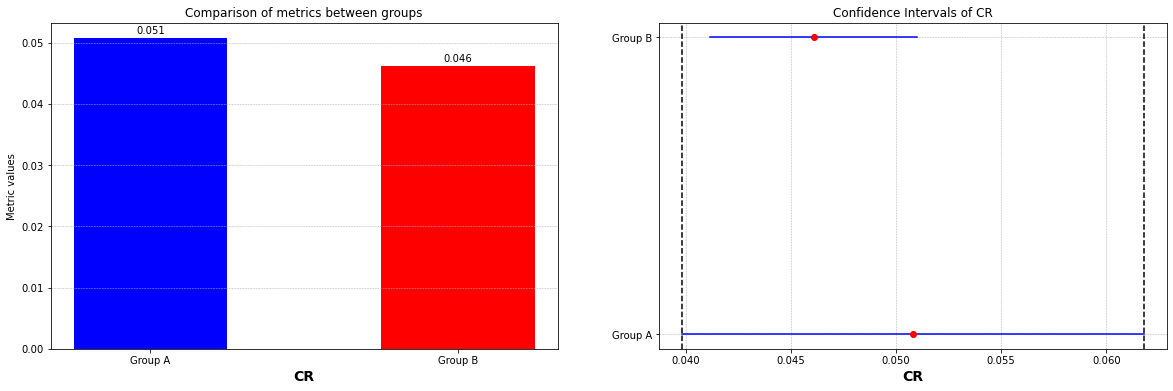

In [22]:
calculator.show_cr()

,Intersect confidence intervals
ARPU,True


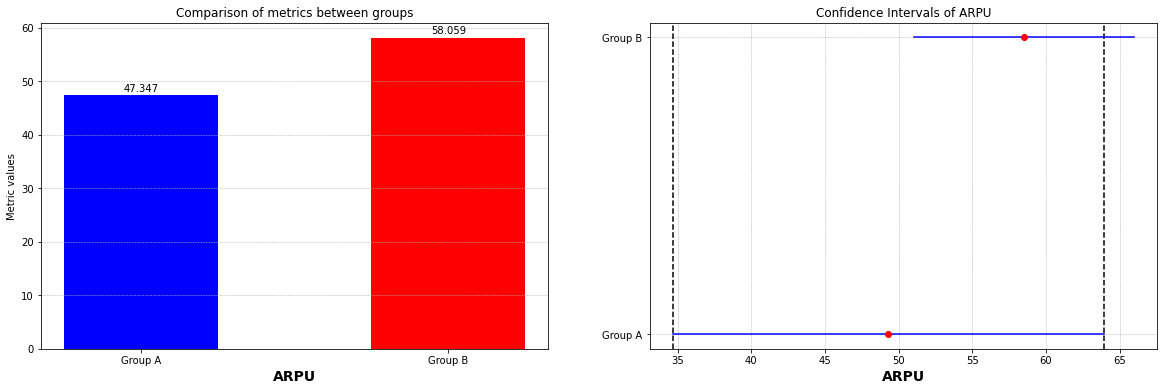

In [23]:
calculator.show_arpu()

,Intersect confidence intervals
ARPPU,False


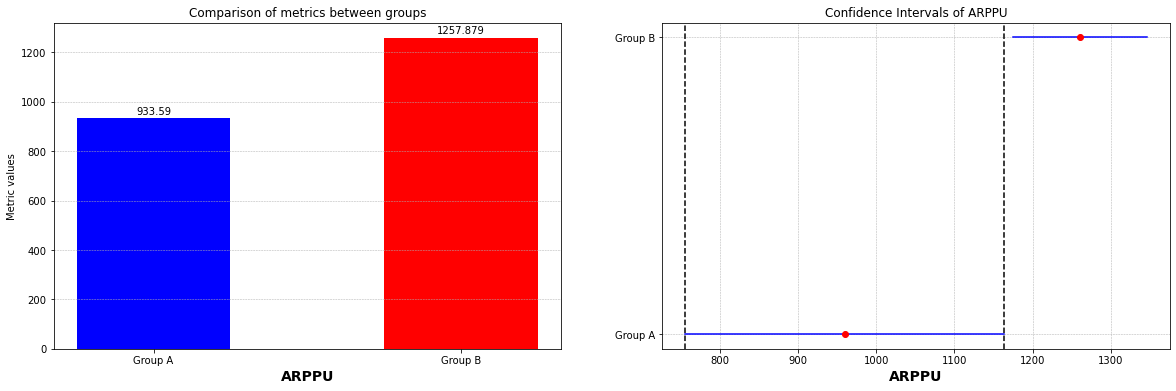

In [24]:
calculator.show_arppu()